In [ ]:
# single-cell analysis package
library(Seurat)

# plotting and data science packages
library(tidyverse)
library(cowplot)
library(patchwork)

# co-expression network analysis packages:
library(WGCNA)
library(hdWGCNA)

# using the cowplot theme for ggplot
theme_set(theme_cowplot())

# set random seed for reproducibility
set.seed(12345)

# optionally enable multithreading
enableWGCNAThreads(nThreads = 8)

# load the Zhou et al snRNA-seq dataset
seurat_obj <- readRDS('/data/work/GRN-hdWGCNA/input/Zhou_2020_control_pp.rds'); seurat_obj # Used demo data do external NormalizeData(), FindVariableFeatures() and ScaleData()
setwd("/data/work/GRN-hdWGCNA/test1")

Attaching SeuratObject

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp



Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots


Loading required package: dynamicTreeCut

Loading required package: fastcluster


Attaching package: ‘fastcluster’


The following object is

Allowing parallel execution with up to 8 working processes.


An object of class Seurat 
36601 features across 36671 samples within 1 assay 
Active assay: RNA (36601 features, 2000 variable features)
 2 dimensional reductions calculated: harmony, umap

This Seurat object was originally created using Seruat v4. If you are using Seurat v5, please run this additional command.

In [2]:
seurat_obj <- SeuratObject::UpdateSeuratObject(seurat_obj); seurat_obj; colnames(seurat_obj@meta.data)

Validating object structure

Updating object slots

Ensuring keys are in the proper structure

Ensuring feature names don't have underscores or pipes

Object representation is consistent with the most current Seurat version



An object of class Seurat 
36601 features across 36671 samples within 1 assay 
Active assay: RNA (36601 features, 2000 variable features)
 2 dimensional reductions calculated: harmony, umap

[1] "orig.ident"              "nCount_RNA"             
 [3] "nFeature_RNA"            "orig_barcode"           
 [5] "n_counts"                "doublet_scores"         
 [7] "doublets"                "Sample"                 
 [9] "Study"                   "batch"                  
[11] "barcode"                 "individualID"           
[13] "specimenID"              "group"                  
[15] "msex"                    "apoe_genotype"          
[17] "age_death"               "pmi"                    
[19] "braaksc"                 "ceradsc"                
[21] "cogdx"                   "n_genes_by_counts"      
[23] "log1p_n_genes_by_counts" "total_counts"           
[25] "log1p_total_counts"      "total_counts_mt"        
[27] "log1p_total_counts_mt"   "pct_counts_mt"          
[29] "leiden"                  "cell_type"              
[31] "annotation"              "UMAP_1"                 
[33] "UMAP_2"

Here we will plot the UMAP colored by cell type just to check that we have loaded the data correctly, and to make sure that we have grouped cells into clusters and cell types.

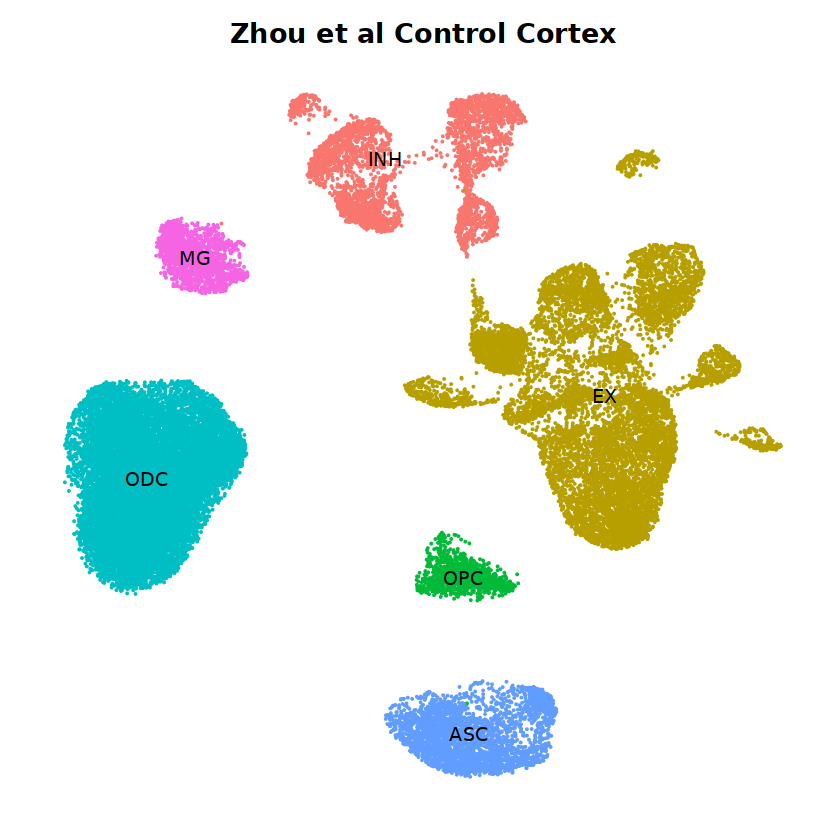

In [3]:
p <- DimPlot(seurat_obj, group.by='cell_type', label=TRUE) +
   umap_theme() + ggtitle('Zhou et al Control Cortex') + NoLegend()

p

# Set up Seurat object for WGCNA
Before running hdWGCNA, we first have to set up the Seurat object. Most of the information computed by hdWGCNA is stored in the Seurat object’s @misc slot, and all of this information can be retrieved by various getter and setter functions. A single Seurat object can hold multiple hdWGCNA experiments, for example representing different cell types in the same single-cell dataset. Notably, since we consider hdWGCNA to be a downstream data analysis step, we do not support subsetting the Seurat object after SetupForWGCNA has been run.

Here we will set up the Seurat object using the SetupForWGCNA function, specifying the name of the hdWGNCA experiment. This function also selects the genes that will be used for WGCNA. The user can select genes using three different approaches using the gene_select parameter:

    variable: use the genes stored in the Seurat object’s VariableFeatures.
    fraction: use genes that are expressed in a certain fraction of cells for in the whole dataset or in each group of cells, specified by group.by.
    custom: use genes that are specified in a custom list.
In this example, we will select genes that are expressed in at least 5% of cells in this dataset, and we will name our hdWGCNA experiment “tutorial”.

In [4]:
seurat_obj <- SetupForWGCNA(
  seurat_obj,
  gene_select = "fraction", # the gene selection approach
  fraction = 0.05, # fraction of cells that a gene needs to be expressed in order to be included
  wgcna_name = "tutorial" # the name of the hdWGCNA experiment
)

# Construct metacells
After we have set up our Seurat object, the first step in running the hdWGCNA pipeine in hdWGCNA is to construct metacells from the single-cell dataset. Briefly, metacells are aggregates of small groups of similar cells originating from the same biological sample of origin. The k-Nearest Neighbors (KNN) algorithm is used to identify groups of similar cells to aggregate, and then the average or summed expression of these cells is computed, thus yielding a metacell gene expression matrix. The sparsity of the metacell expression matrix is considerably reduced when compared to the original expression matrix, and therefore it is preferable to use. We were originally motivated to use metacells in place of the original single cells because correlation network approaches such as WGCNA are sensitive to data sparsity.

hdWGCNA includes a function MetacellsByGroups to construct metacell expression matrices given a single-cell dataset. This function constructs a new Seurat object for the metacell dataset which is stored internally in the hdWGCNA experiment. The group.by parameter determines which groups metacells will be constructed in. We only want to construct metacells from cells that came from the same biological sample of origin, so it is critical to pass that information to hdWGCNA via the group.by parameter. Additionally, we usually construct metacells for each cell type separately. Thus, in this example, we are grouping by Sample and cell_type to achieve the desired result.

The number of cells to be aggregated k should be tuned based on the size of the input dataset, in general a lower number for k can be used for small datasets. We generally use k values between 20 and 75. The dataset used for this tutorial has 40,039 cells, ranging from 890 to 8,188 in each biological sample, and here we used k=25. The amount of allowable overlap between metacells can be tuned using the max_shared argument. There should be a range of K values that are suitable for reducing the sparsity while retaining cellular heterogeneity for a given dataset, rather than a single optimal value.

Note: we have found that the metacell aggregation approach does not yield good results for extremely underrepresented cell types. For example, in this dataset, the brain vascular cells (pericytes and endothelial cells) were the least represented, and we have excluded them from this analysis. MetacellsByGroups has a parameter min_cells to exclude groups that are smaller than a specified number of cells. Errors are likely to arise if the selected value for min_cells is too low.

Here we construct metacells and normalize the resulting expression matrix using the following code:

In [5]:
# construct metacells  in each group
seurat_obj <- MetacellsByGroups(
  seurat_obj = seurat_obj,
  group.by = c("cell_type", "Sample"), # specify the columns in seurat_obj@meta.data to group by
  reduction = 'harmony', # select the dimensionality reduction to perform KNN on
  k = 25, # nearest-neighbors parameter
  max_shared = 10, # maximum number of shared cells between two metacells
  ident.group = 'cell_type' # set the Idents of the metacell seurat object
)

# normalize metacell expression matrix:
seurat_obj <- NormalizeMetacells(seurat_obj)

Warning message in MetacellsByGroups(seurat_obj = seurat_obj, group.by = c("cell_type", :
“Removing the following groups that did not meet min_cells: ASC#C4, MG#C2, MG#C3, MG#C4, ODC#C4, OPC#C12, OPC#C4, OPC#C9”


# Optional: Process the Metacell Seurat Object
Since we store the Metacell expression information as its own Seurat object, we can run Seurat functions on the metacell data. We can get the metacell object from the hdWGCNA experiment using GetMetacellObject.

In [6]:
metacell_obj <- GetMetacellObject(seurat_obj)

Additionally, we have included a few wrapper functions to apply the Seurat workflow to the metacell object within the hdWGCNA experiment. Here we apply these wrapper functions to process the metacell object and visualize the aggregated expression profiles in two dimensions with UMAP.

Centering and scaling data matrix

PC_ 1 
Positive:  NEAT1, LINC01170, SLC5A11, AC012494.1, AL033523.1, GLUL, LINC02073, AC008571.2, HIST1H2AC, ITPKB 
	   ROR1, PLPP3, ERBB4, ACSS1, FTH1, SLC6A1, LURAP1L-AS1, LINC01505, SPP1, LINC01098 
	   SEMA3C, ABI3BP, FTL, B2M, EYA4, PDLIM5, SLC1A3, SAMMSON, PLD5, ADAMTS18 
Negative:  GABRB3, KALRN, CNKSR2, DCLK1, GABBR2, STXBP5L, FRMPD4, LRFN5, HECW1, GRIN2B 
	   GALNT17, DLGAP2, ATRNL1, PCLO, KCNQ5, SH3GL2, HCN1, RBFOX3, SYN2, PRICKLE1 
	   PCSK2, CACNA1B, FGF12, CDH18, CACNA1C, GRM5, NELL2, CCSER1, KCTD16, CABP1 
PC_ 2 
Positive:  PDE1A, IQCJ-SCHIP1, VSTM2B, LINC01122, RYR2, KCNK1, ROBO1, SEMA3C, SEMA6D, KCNH1 
	   GRID2, STMN1, AC012494.1, LINC01170, SPANXA2-OT1, CDH8, SLC5A11, LAMA2, TTC6, WASF1 
	   RTN1, DCC, CDH13, LINC02073, AC008571.2, AL033523.1, SLIT2, PRKCB, SV2B, ARPP21 
Negative:  NHSL1, STON2, EZR, NOTCH2, PLSCR4, YAP1, APOE, CGNL1, GFAP, EFEMP1 
	   F3, ALDH1L1, CST3, GLI3, FGFR3, ARHGEF26, FAM189A2, BMPR1B, FGF2, FAM107A 
	   STK

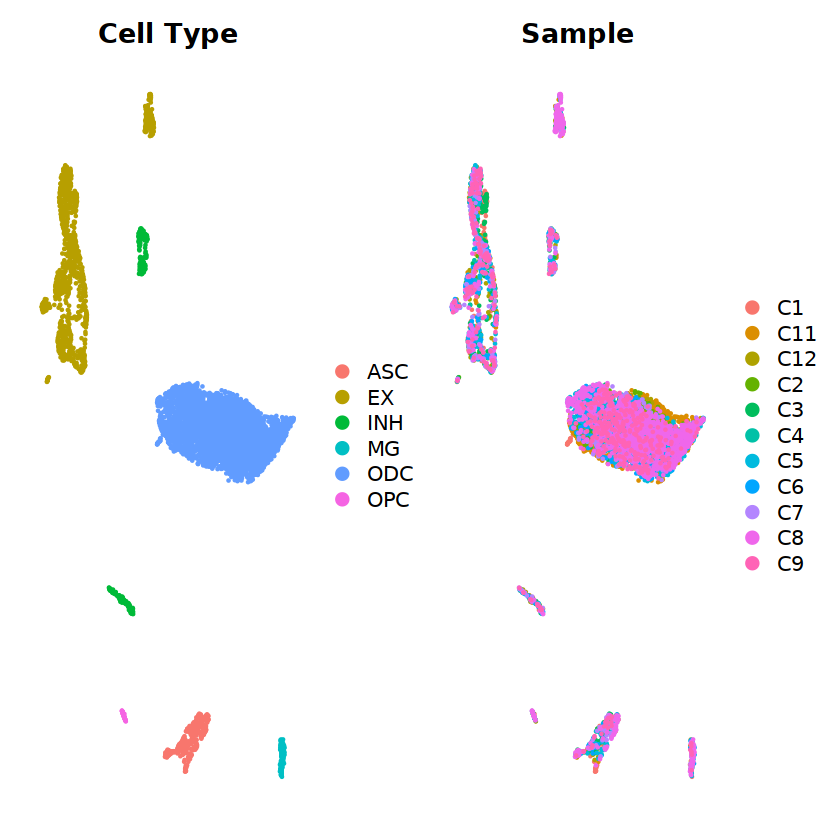

In [7]:
seurat_obj <- NormalizeMetacells(seurat_obj)
seurat_obj <- ScaleMetacells(seurat_obj, features=VariableFeatures(seurat_obj))
seurat_obj <- RunPCAMetacells(seurat_obj, features=VariableFeatures(seurat_obj))
seurat_obj <- RunHarmonyMetacells(seurat_obj, group.by.vars='Sample')
seurat_obj <- RunUMAPMetacells(seurat_obj, reduction='harmony', dims=1:15)


p1 <- DimPlotMetacells(seurat_obj, group.by='cell_type') + umap_theme() + ggtitle("Cell Type")
p2 <- DimPlotMetacells(seurat_obj, group.by='Sample') + umap_theme() + ggtitle("Sample")

p1 | p2

# Co-expression network analysis
In this section we discuss how to perform co-expression network analysis with hdWGNCA on the inhibitory neuron (INH) cells in our example dataset.

Set up the expression matrix
Here we specify the expression matrix that we will use for network analysis. Since We only want to include the inhibitory neurons, so we have to subset our expression data prior to constructing the network. hdWGCNA includes the SetDatExpr function to store the transposed expression matrix for a given group of cells that will be used for downstream network analysis. The metacell expression matrix is used by default (use_metacells=TRUE), but hdWGCNA does allow for the single-cell expression matrix to be used if desired.. This function allows the user to specify which slot/layer to take the expression matrix from, for example if the user wanted to apply SCTransform normalization instead of NormalizeData.

In [8]:
seurat_obj <- SetDatExpr(
  seurat_obj,
  group_name = "INH", # the name of the group of interest in the group.by column
  group.by='cell_type', # the metadata column containing the cell type info. This same column should have also been used in MetacellsByGroups
  assay = 'RNA', # using RNA assay
  layer = 'data' # using normalized data
)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.7 GiB”


**Selecting more than one group**:
Suppose that you want to perform co-expression network analysis on more than one cell type or cluster simultaneously. SetDatExpr can be run with slighly different settings to achieve the desired result by passing a character vector to the group_name parameter.

In [9]:
# seurat_obj <- SetDatExpr(
#   seurat_obj,
#   group_name = c("INH", "EX"),
#   group.by='cell_type'
# )

# Select soft-power threshold
Next we will select the “soft power threshold”. This is an extremely important step in the hdWGNCA pipleine (and for vanilla WGCNA). hdWGCNA constructs a gene-gene correlation adjacency matrix to infer co-expression relationships between genes. The correlations are raised to a power to reduce the amount of noise present in the correlation matrix, thereby retaining the strong connections and removing the weak connections. Therefore, it is critical to determine a proper value for the soft power threshold.

We include a function TestSoftPowers to perform a parameter sweep for different soft power thresholds. This function helps us to guide our choice in a soft power threshold for constructing the co-expression network by inspecting the resulting network topology for different power values. The co-expression network should have a [scale-free topology](https://en.wikipedia.org/wiki/Scale-free_network), therefore the TestSoftPowers function models how closely the co-expression network resembles a scale-free graph at different soft power thresholds. Furthermore, we include a function PlotSoftPowers to visualize the results of the parameter sweep.

The following code performs the parameter sweep and outputs a summary figure.

pickSoftThreshold: will use block size 3539.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 3539 of 12639
   ..working on genes 3540 through 7078 of 12639
   ..working on genes 7079 through 10617 of 12639
   ..working on genes 10618 through 12639 of 12639
   Power SFT.R.sq slope truncated.R.sq  mean.k. median.k.  max.k.
1      1   0.2610 11.90          0.955 6.53e+03  6.53e+03 7220.00
2      2   0.0163  1.38          0.994 3.43e+03  3.42e+03 4290.00
3      3   0.0418 -1.49          0.978 1.84e+03  1.82e+03 2650.00
4      4   0.2980 -3.25          0.959 1.00e+03  9.78e+02 1720.00
5      5   0.5580 -4.06          0.962 5.57e+02  5.33e+02 1160.00
6      6   0.7050 -4.20          0.970 3.15e+02  2.95e+02  804.00
7      7   0.7860 -4.16          0.979 1.81e+02  1.65e+02  575.00
8      8   0.8480 -3.96          0.986 1.06e+02  9.34e+01  422.00
9      9   0.8580 -3.85          0.967 6.36e+01  5.37e+01  316.00
10    10   0.8700 -3.72          0

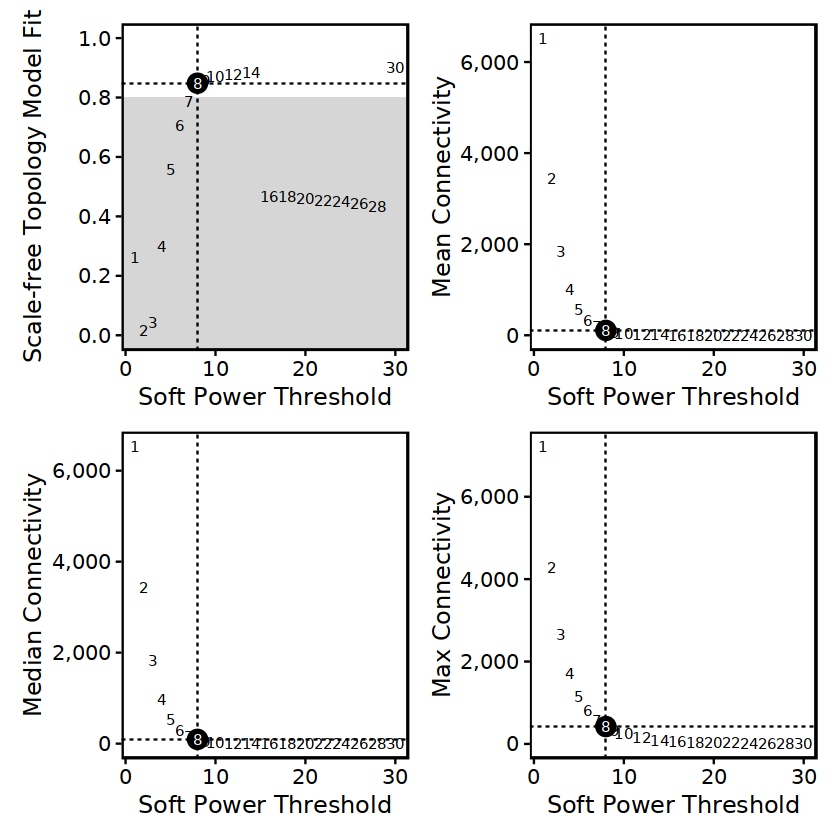

In [10]:
# Test different soft powers:
seurat_obj <- TestSoftPowers(
  seurat_obj,
  networkType = 'signed' # you can also use "unsigned" or "signed hybrid"
)

# plot the results:
plot_list <- PlotSoftPowers(seurat_obj)

# assemble with patchwork
wrap_plots(plot_list, ncol=2)

The general guidance for WGCNA and hdWGCNA is to pick the lowest soft power threshold that has a Scale Free Topology Model Fit greater than or equal to 0.8, so in this case we would select our soft power threshold as 9. Later on, the ConstructNetwork will automatically select the soft power threshold if the user does not provide one.

Tthe output table from the parameter sweep is stored in the hdWGCNA experiment and can be accessed using the `GetPowerTable` function for further inspection:

In [11]:
power_table <- GetPowerTable(seurat_obj)
head(power_table)

,Power,SFT.R.sq,slope,truncated.R.sq,mean.k.,median.k.,max.k.
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0.26110351,11.889729,0.9546294,6525.7417,6532.2923,7219.7053
2,2,0.01631495,1.375111,0.9935408,3434.0090,3421.8601,4293.1289
3,3,0.04178826,-1.487314,0.9784280,1840.1686,1817.2352,2651.0575
4,4,0.29769630,-3.249674,0.9588046,1003.7962,978.3657,1719.7194
5,5,0.55846894,-4.060086,0.9617106,557.3639,533.2201,1157.0353
6,6,0.70513240,-4.195496,0.9696135,315.0681,295.1368,804.1011


# Construct co-expression network
We now have everything that we need to construct our co-expression network. Here we use the hdWGCNA function ConstructNetwork, which calls the WGCNA function blockwiseConsensusModules under the hood. This function has quite a few parameters to play with if you are an advanced user, but we have selected default parameters that work well with many single-cell datasets. The parameters for blockwiseConsensusModules can be passed directly to ConstructNetwork with the same parameter names.

The following code construtcts the co-expression network using the soft power threshold selected above:

In [12]:
# construct co-expression network:
seurat_obj <- ConstructNetwork(
  seurat_obj,
  tom_name = 'INH' # name of the topoligical overlap matrix written to disk
)

Soft power not provided. Automatically using the lowest power that meets 0.8 scale-free topology fit. Using soft_power = 8
 Calculating consensus modules and module eigengenes block-wise from all genes
 Calculating topological overlaps block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
    TOM calculation: adjacency..
    ..will use 8 parallel threads.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
 ..Working on block 1 .
 ..Working on block 1 .
 ..merging consensus modules that are too close..


hdWGCNA also includes a function PlotDendrogram to visualize the WGCNA dendrogram, a common visualization to show the different co-expression modules resulting from the network analysis. Each leaf on the dendrogram represents a single gene, and the color at the bottom indicates the co-expression module assignment.

**Importantly, the “grey” module consists of genes that were not grouped into any co-expression module. The grey module should be ignored for all downstream analysis and interpretation.**

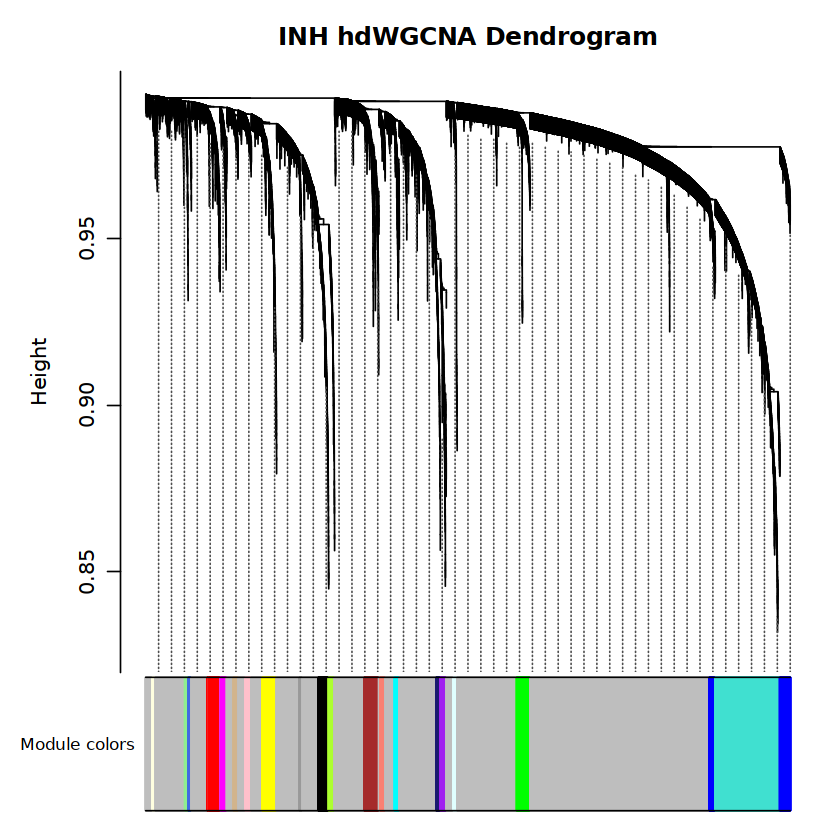

In [13]:
PlotDendrogram(seurat_obj, main='INH hdWGCNA Dendrogram')

# Optional: inspect the topoligcal overlap matrix (TOM)
hdWGCNA represents the co-expression network as a topoligcal overlap matrix (TOM). This is a square matrix of genes by genes, where each value is the topoligcal overlap between the genes. The TOM is written to the disk when running ConstructNetwork, and we can load it into R using the GetTOM function. Advanced users may wish to inspect the TOM for custom downstream analyses.

In [14]:
TOM <- GetTOM(seurat_obj)

# Module Eigengenes and Connectivity
In this section we will cover how to compute module eigengenes in single cells, and how to compute the eigengene-based connectivity for each gene.

# Compute harmonized module eigengenes
Module Eigengenes (MEs) are a commonly used metric to summarize the gene expression profile of an entire co-expression module. Briefly, module eigengenes are computed by performing principal component analysis (PCA) on the subset of the gene expression matrix comprising each module. The first PC of each of these PCA matrices are the MEs.

Dimensionality reduction techniques are a very hot topic in single-cell genomics. It is well known that technical artifacts can muddy the analysis of single-cell datasets, and over the years there have been many methods that aim to reduce the effects of these artifacts. Therefore it stands to reason that MEs would be subject to these technical artifacts as well, and hdWGCNA seeks to alleviate these effects.

hdWGCNA includes a function ModuleEigengenes to compute module eigengenes in single cells. Additionally, we allow the user to apply Harmony batch correction to the MEs, yielding harmonized module eigengenes (hMEs). The following code performs the module eigengene computation harmonizing by the Sample of origin using the group.by.vars parameter.

In [15]:
# need to run ScaleData first or else harmony throws an error:
#seurat_obj <- ScaleData(seurat_obj, features=VariableFeatures(seurat_obj))

# compute all MEs in the full single-cell dataset
seurat_obj <- ModuleEigengenes(
 seurat_obj,
 group.by.vars="Sample"
)

[1] "grey"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcagrey to pcagrey_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcagrey_”
pcagrey_ 1 
Positive:  ST18, TMEM144, TF, ENPP2, PTGDS, CLMN, AL359091.1, ERBIN, MOG, CLDN11 
	   CREB5, COL4A5, CERCAM, BCAS1, MOBP, FAM107B, KCNH8, SLC7A14-AS1, ABCA8, ABCA2 
	   SLAIN1, MAN2A1, CLDND1, CNP, LAMP2, PLD1, VRK2, CNTN2, FGFR2, FRYL 
Negative:  FAM155A, PLCB1, CSMD1, CELF2, CACNA1C, FRMPD4, DCLK1, MAP2, PTPRN2, KCNQ5 
	   KCNMA1, SCN2A, GABBR2, GRIN2B, KHDRBS2, CDH18, CAMK1D, HECW1, EFNA5, SNTG1 
	   MRTFB, PAK3, ATP2B2, SCN8A, NRCAM, MIR124-2HG, CACNA1A, DNM1, KCNJ3, RAPGEF4 
pcagrey_ 2 
Positive:  SLC1A2, GFAP, ATP1A2, STON2, ADGRV1, PITPNC1, F3, NHSL1, EFEMP1, GJA1 
	   SLC1A3, PLSCR4, ALDH1L1, FAM189A2, OBI1-AS1, APOE, YAP1, MRVI1, RGS20, PRDM16 
	   SLCO1C1, GLI3, FGFR3, AC

[1] "red"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcared to pcared_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcared_”
pcared_ 1 
Positive:  SLCO1A2, CTNNA3, RNF130, SLC22A15, UACA, AGAP1, CCDC88A, KNOP1, NOTCH1, FAM227B 
	   AC002451.1, LINC02649, AC119674.1, GABPB1-AS1, COMMD10, MLH3, RREB1, AC007221.1, IL3RA, AC091180.5 
	   CAPS, AL596218.1, NOL8, DNM2, AC012464.1, ZNF404, EFCAB13, AC099489.1, BPTF, AC097376.3 
Negative:  STXBP5L, CACNA1B, OPCML, MYT1L, ANKRD30BL, GRIN1, BMS1P14, SNAP91, FRMD4A, CHD5 
	   FP700111.1, VPS13A, PRSS51, KNDC1, SIMC1, NEXMIF, AC008696.2, CEP112, LINC01278, LINC00632 
	   AC092683.2, AP001266.2, FBXO16, ANKRD26, LINC02263, HIVEP3, SPIDR, LINC01410, AL117190.2, AC108519.1 
pcared_ 2 
Positive:  CTNNA3, AGAP1, MALAT1, SLCO1A2, RNF130, SLC22A15, CCDC88A, TNRC6C, DOCK3, MICAL3 
	   BPT

[1] "blue"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcablue to pcablue_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcablue_”
pcablue_ 1 
Positive:  MEG3, CYP4X1, CORO6, NEIL1, ZNF382, SLC35A1, GOLT1B, MYEF2, DPH1, ZFAND1 
	   HMGN3, NNT, AL391807.1, OTUD3, ZNF391, SRSF11, SLC29A1, ZNF540, CSNKA2IP, VSTM2A 
	   NIPSNAP3B, LUC7L, AL512625.2, REX1BD, SHFL, DYNC2LI1, TBRG1, YTHDC2, RSRP1, PMS2 
Negative:  TMEM165, FBXO7, LINC02340, ZKSCAN1, SEPSECS, CIRBP, ADHFE1, SLC35B3, WSB1, GSTK1 
	   HSD17B7, RNF13, LANCL1, GTF2H2C, RWDD3, ZC3H11A, SRD5A3, XPNPEP3, TMEM246, UFL1 
	   ZNF555, TLCD5, GTPBP10, AC083870.1, SRP54, IFNGR1, TMEM50B, TRMT10B, ILKAP, ENTHD1 
pcablue_ 2 
Positive:  MEG3, VSTM2A, CYP4X1, REX1BD, NIPSNAP3B, ZNF391, ZYX, PRRT2, SLC29A1, NEIL1 
	   SLC35A1, BOLA3, CORO6, MPP1, OTUD3, CSNKA2IP, DPP7, C2CD5, MYEF

[1] "green"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcagreen to pcagreen_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcagreen_”
pcagreen_ 1 
Positive:  MYO6, AL139383.1, ZFYVE16, OSBPL9, CLASP2, RFX3-AS1, ZNF280D, ZBED5, PPP1R21, ENTPD1-AS1 
	   AL162253.2, GANC, ZCWPW1, LRCH3, MRPL48, ENO4, CTNNA1, CCDC18-AS1, THAP6, UVSSA 
	   ADCK1, SLC38A9, COA6-AS1, AC138150.1, SHPK, TPCN1, PAAF1, TAGLN, ZC3H6, FKBP15 
Negative:  UNC80, AC024901.1, FAM153B, FAM27C, STAT4, FAM153A, LINC02398, MEF2C-AS1, AEBP2, PNMA3 
	   SLC25A12, SRGAP3, CFAP69, RNF175, TRMT11, TTC8, SUGP2, NOXA1, SULT1A1, GPLD1 
	   LINC02245, ARMC2, AC104806.2, MIR2052HG, RFLNA, ZNF248, AC015943.1, CAPRIN2, ATAD2, SNHG27 
pcagreen_ 2 
Positive:  CLASP2, MYO6, ZNF280D, ZFYVE16, OSBPL9, PPP1R21, ZBED5, CTNNA1, RFX3-AS1, CCDC18-AS1 
	   LRCH3, BIRC6, AL139383.1,

[1] "lightcyan"


Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcalightcyan to pcalightcyan_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcalightcyan_”
pcalightcyan_ 1 
Positive:  SIK3, DIP2C, TFEB, GAB2, MYO9B, TOB2, ARL8A, CST3, NOL4L, ABHD17A 
	   ADAP1, HCN2, BRSK1, JMJD6, MTSS2, CSMD2, STK40, ZMIZ1, NECTIN1, CSNK1E 
	   MAP2K2, GNB1, UPF1, MEF2D, BRD4, KDM6B, H1FX, CBARP, ZBTB4, YWHAE 
Negative:  MT-CO3, MT-CYB, MT-CO1, MT-ND1, MT-ATP6, MT-CO2, MT-ND4L, MT-ND5, MT-ND4, MT-ND3 
	   MTRNR2L12, DHFR, MT-ND2, LINC01320, MTRNR2L1, MTRNR2L8, MT-ATP8, MT-ND6, NPTX1, NCS1 
	   MTRNR2L6, FBXL16, NSF, DGKZ, NEFM, ABR, ADGRB1, PTMS, PDXK, PPFIA3 
pcalightcyan_ 2 
Positive:  MTRNR

[1] "yellow"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcayellow to pcayellow_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcayellow_”
pcayellow_ 1 
Positive:  QKI, MBP, SGK1, GPRC5B, SCD, CLIC4, FBXL7, NDRG1, SPOCK1, PTBP2 
	   FMNL2, SLC39A11, DOCK9, TXNIP, SGMS1, SH3GL3, OLMALINC, DAPK2, IGSF11, LSS 
	   CA2, TBC1D2, AKAP6, MEGF9, TMEFF2, UNC5B, AC012178.1, PLPP3, EEPD1, INSIG1 
Negative:  FGF14, CCSER1, AFF3, MSRA, RBFOX3, RIMS1, CDK14, FLRT2, TMEM132D, NR2F1-AS1 
	   GRIN2A, PHACTR1, CABP1, MACROD2, RIMBP2, KCNQ3, ATP8A2, SLC2A13, UNC13A, PLXNA2 
	   PDZRN3, PTPRO, UNC13C, GALNT18, DGCR9, POU6F2, PRKAR2B, KCNH5, NYAP2, FSTL5 
pcayellow_ 2 
Positive:  SH3GL3, AKAP6, GAS7, SAMD12, TMEFF2, GRIN2A, PPFIBP1, ATP8A2, CACNA2D1, MBP 
	   DOCK9, RBFOX3, CABP1, SPOCK1, AFF3, CCSER1, SGK1, ADAM22, DGCR9, RHOBTB1 
	   SYNDIG1,

[1] "turquoise"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcaturquoise to pcaturquoise_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcaturquoise_”
pcaturquoise_ 1 
Positive:  GLUL, DNAJC6, MARCKSL1, SHC4, MAT2A, C12orf76, SF1, ENDOD1, MAP4, APLP1 
	   FAM177A1, CFL2, NCOA7, B2M, GOLGA7, JPX, COPA, TMX1, PPP4R3B, FEZ1 
	   IFI27L2, EIF5A2, STMN4, FADS1, HMGN1, C1orf122, TMEM258, TUBA1A, IL6ST, SCARB2 
Negative:  SNAP25, CALM1, UCHL1, HSP90AB1, RAB3A, SNCB, NEFL, ATP6V0C, PCSK1N, ATP1A3 
	   TMEM59L, CALM3, MAP1B, RTN1, ENO2, GAPDH, CHGA, SYP, STMN2, MDH1 
	   ARL6IP1, YWHAG, YWHAH, TUBA1B, PKM, CLSTN1, TSPAN7, TUBB2A, IDS, SERINC1 
pcaturquoise_ 2 
Positive:  GABRG2, ATCAY, ST8SIA3, SLC12A5, ELMOD1, RTN1, SYP, LONRF2, SLC6A17, NDRG4 
	   SV2A, PHYHIP, NSG2, MAP1B, CLSTN3, ATP1A3, DMTN, KIF5A, KIAA0513, TMEM130 
	   PGM2L1, 

[1] "cyan"


Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcacyan to pcacyan_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcacyan_”
pcacyan_ 1 
Positive:  SYT1, SYN2, UNC5D, KCTD16, GRIP1, AMPH, MCTP1, PTPRT, PAK5, AC073050.1 
	   TENM4, SLC35F1, PPP3CA, LIN7A, DOK6, BRINP2, PTCHD4, TRERF1, PRKCE, MPPED1 
	   R3HDM1, SGCZ, TOX, DPP6, GRIA4, NTRK2, PIP5K1B, RBMS3, KAZN, PLCXD3 
Negative:  ELMO1, PDE8A, TCF12, UNC5C, FAM13C, ZSWIM6, IL1RAPL1, KIAA1324L, SSH2, GRID1 
	   ADAM12, DSCAML1, ADD3, PKP4, KIRREL3, ZNF462, RERE, POLA1, DGKD, KANSL1L 
	   MGAT5, HECW2, RASSF8, TSPAN5, RAB3IP, MYH9, ZNF827, GOLIM4, MAP3K20, TOX3 
pcacyan_ 2 
Positive:  IL1RAPL1, DSCAML1, HECW2, UN

[1] "greenyellow"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcagreenyellow to pcagreenyellow_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcagreenyellow_”
pcagreenyellow_ 1 
Positive:  KALRN, RGS7, GABRB3, NRXN1, MTUS2, LINGO2, CSMD3, PCSK2, DGKB, SORCS1 
	   GRIA2, PRKCB, NEDD4L, NRG1, ACTN1, CCDC85A, HTR1E, AC007563.2, MAGI3, EPHA5 
	   SUSD4, NGEF, TTC39C, PRR16, FRY, LRRC7, AC092691.1, RNF150, TNFRSF25, KCTD1 
Negative:  ZBTB20, DOCK10, SOX2-OT, CDH20, LINC01630, SLCO3A1, ZFHX4, NFIA, BAZ2B, EPN2 
	   COBL, FOXO1, NAALADL2, PEX5L, CNTNAP4, GREB1L, MBOAT2, SLC25A48, KIAA1958, PREX2 
	   ANK3, LRIG1, AP1S2, SWAP70, NFIB, MAML3, MN1, PELI2, CLTCL1, ZNF765 
pcagreenyellow_ 2 
Positive:  NKAIN3, TPD52L1, PREX2, EGFR, ARHGEF26-AS1, LRIG1, AC092691.1, KCNN3, GNG12, ADRA1A 
	   CHST11, AF279873.3, LSAMP, RERG, MARCH3, NFIA, NRXN

[1] "brown"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcabrown to pcabrown_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcabrown_”
pcabrown_ 1 
Positive:  RIMS2, RALYL, THRB, CNTN1, GRIK2, ADGRL2, TMEM178B, ROBO2, NETO1, CERS6 
	   CELF4, CHL1, CTNNA2, PTPRR, SLC8A1, GPM6A, DAPK1, KIAA1211L, GRM1, ANO5 
	   CACNG3, CDH9, DGKI, CAMK2A, BCL11A, SMYD3, FZD3, RUNDC3B, WDR17, SYT7 
Negative:  FRMD4B, PHLPP1, TMTC2, LPAR1, DPYD, KLHL32, RBPJ, JAM3, SEMA6A, NEO1 
	   TMCC3, ENOX2, MUSK, DLEU2, FNIP1, EVA1C, FANCL, CDH12, PRKCQ, ANKRD44 
	   MIR100HG, CRYBG3, APOLD1, TLE4, AOX1, LIMCH1, PRTFDC1, SEPTIN10, RAP1GDS1, ZNF704 
pcabrown_ 2 
Positive:  SPON1, RAB31, EYA2, UTRN, GPM6A, MAP3K5, CABLES1, ADCY2, WLS, PCSK5 
	   FARP1, UST, TCF7L1, CRB1, PTCHD1, CTNNA2, PTCHD1-AS, CFAP47, BACH1, LIMS1 
	   SRGAP1, LINC01138, CNTN1, MID1,

[1] "pink"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcapink to pcapink_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcapink_”
pcapink_ 1 
Positive:  SGK2, OCLN, AC109927.1, HDAC1, C5, NASP, NSMCE4A, ADORA1, LINC02762, AC104596.1 
	   MIIP, MDM4, SLC9B1, AL080276.2, ZNF107, FAAH, PATL1, NPHP3, MXD3, ZNF18 
	   AC105942.1, POLR3GL, AL513548.1, DONSON, ZNF226, SLC16A1, NR2C2, NUP107, BBS4, ERCC2 
Negative:  MAP3K21, HECTD4, HERC1, ZDHHC21, TMEM179, TMEM145, ASB3, MDN1, NPIPA1, SNX32 
	   SLC26A8, HACL1, MICU2, SLC18B1, WDR37, TENT4A, KIAA0895L, CHD2, GK5, AGO4 
	   UPF3A, TFR2, EP400, NPEPL1, CYP2E1, ZNF721, ATRN, TNKS2, SCFD1, DCUN1D4 
pcapink_ 2 
Positive:  AC104596.1, NASP, SGK2, MDM4, NPHP3, TLK2, AC109927.1, OCLN, ZNF226, L3MBTL1 
	   DNHD1, RBM5, UBA6, GIGYF2, CDC16, SLC9B1, C5, SNRNP70, GTF2I, C2CD6 
	   NR2C2, F

[1] "magenta"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcamagenta to pcamagenta_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcamagenta_”
pcamagenta_ 1 
Positive:  NEAT1, EDIL3, KAT2B, CDC14B, SLC25A13, ANO4, SNX29, GNG7, ARHGAP22, TNS1 
	   CYP7B1, ERBB4, AMPD3, PPP1R12B, BARD1, OTUD7A, PPARA, LPP, PCBP4, NOX4 
	   TTLL9, KLHL13, AUH, LCNL1, PC, EPHX2, AC011997.1, SPECC1, STX6, AL158071.3 
Negative:  NRG3, MEG8, ASIC2, CNTN4, SRRM4, HS6ST3, PLXNA4, NTRK3, XKR6, KCNH7 
	   SLC35F3, NOL4, PPM1E, PPFIA4, NEK10, FHOD3, DZIP1, SLIT1, LINC01414, ABLIM2 
	   COL26A1, RARB, AC096711.2, ZFYVE28, DLGAP4, SGPP2, DENND1B, FAM13A, SDK1, AC092422.1 
pcamagenta_ 2 
Positive:  EDIL3, ANO4, STOX2, KCNK1, OSBP2, NUAK1, OTUD7A, SLC35F3, ABLIM2, SRRM4 
	   COL26A1, KCNH7, SLIT1, SYT14, SGPP2, PPP1R12B, CNTN4, ASIC2, PPFIA4, PLXNA4 
	   MC

[1] "royalblue"


Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcaroyalblue to pcaroyalblue_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcaroyalblue_”
Warning message:
“Requested number is larger than the number of available items (59). Setting to 59.”
Warning message:
“Requested number is larger than the number of available items (59). Setting to 59.”
Warning message:
“Requested number is larger than the number of available items (59). Setting to 59.”
Warning message:
“Requested number is larger than the number of available items (59). Setting to 59.”
Warning message:
“Requested number is larger than the number of available items (59). Setting to 59.”
pcaroyalblue_ 1 
Pos

[1] "midnightblue"


Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcamidnightblue to pcamidnightblue_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcamidnightblue_”
pcamidnightblue_ 1 
Positive:  FGF12, DLGAP2, HCN1, MDGA2, LRRTM4, TAFA2, KCNC2, KCND2, DPP10, SETBP1 
	   NAV3, LDB2, MEF2C, ERC2, ADCY1, EPHA6, NDST3, KLF12, FAM78B, ZNF385D 
	   SLIT2, ADARB1, WIPF3, SOX5, MPP7, PPARGC1A, EPB41, SLC26A4, MYO1B, ANK1 
Negative:  PLCL1, HHATL, PTPN13, SLC9A9, CDK6, ROR1, TAFA4, LINC00894, UBE2E2, MEF2A 
	   AFF1, CEMIP, TEAD1, RNF144B, CPED1, CNTNAP3C, RUNX2, TMEM132C, ANKS1A, MYO5B 
	   RGS5, KCNS3, RPH3AL, GAS2, SLC4A4, ST8SIA4, GPAT3, KCTD8, CLEC16A, DNAI1 
pcamidnightblue_ 2 
P

[1] "tan"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcatan to pcatan_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcatan_”
pcatan_ 1 
Positive:  NAIP, WWOX, CPQ, PACS2, SLC4A5, VPS35L, P2RX7, AC053527.2, GUSB, AP002495.1 
	   SLC13A3, ADCY5, MCM9, PPCDC, SYCP2, KCNQ1, BCL7C, DNAJC27-AS1, AL683813.1, DPH6 
	   LINC01376, TAF1, ANKAR, PRIM2, ELOA-AS1, AC021231.1, AC008537.2, PZP, DIPK1A, SZT2 
Negative:  JPH4, DAB1, TARBP1, UPP2, AL445433.2, LRRN2, AL591519.1, AC079781.5, CCDC171, LINC00937 
	   AL353626.1, CCDC192, AC092745.5, CCDC3, NEK11, AL357153.2, ALG1L9P, SYCE1, ECT2L, PKD1L1 
	   AC092574.2, SYCP2L, XYLB, DNAAF1, FBXL13, ZNF675, TNRC6B, CC2D1A, PILRB, C20orf194 
pcatan_ 2 
Positive:  WWOX, SLC13A3, LUC7L3, PACS2, CPQ, NAIP, AC053527.2, VPS35L, GUSB, SYCP2 
	   AC025159.1, SLC4A5, P2RX7, PCBP1-AS1, ADCY5, LINC01

[1] "purple"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcapurple to pcapurple_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcapurple_”
pcapurple_ 1 
Positive:  DLGAP1, RBFOX1, GRM5, AGBL4, ATRNL1, SLC4A10, LRFN5, CADPS, TENM2, PCLO 
	   CACNB4, ZNF385B, SORBS2, NEGR1, XKR4, ST6GALNAC5, SH3GL2, RYR2, MMP16, PAM 
	   SYBU, KIAA1217, GRIA3, AC090578.1, MICAL2, TMEM178A, STXBP5-AS1, SATB1-AS1, ANKRD34C-AS1, MAPK10 
Negative:  PIEZO2, MIR181A1HG, SPOCK3, PPP2R2B, SLC24A2, AOPEP, TANC1, FHIT, ST6GALNAC3, SASH1 
	   MITF, RAPGEF6, RAPGEF5, STARD9, SFMBT2, PKD2, STXBP6, MAGI2, DIPK2A, ENOX1 
	   AC104123.1, AKNA, AL158077.2, ZNF124, PTPRM, ETV6, ASTN2, BLM, JARID2, PLOD2 
pcapurple_ 2 
Positive:  DTNA, SPARCL1, ETV6, AHCYL2, PRKG1, PLOD2, SFMBT2, ANTXR1, TRIO, SOX6 
	   MAPK10, ADCY8, ST8SIA1, TMTC1, JARID2, AF117829.1, TLN2, A

[1] "salmon"


Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcasalmon to pcasalmon_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcasalmon_”
pcasalmon_ 1 
Positive:  LRRC8D, AF165147.1, LHPP, AC011346.1, MYO18A, SCGB2B2, NUBPL, FGGY, AC007376.2, RNF213 
	   RSRC1, GLIDR, PCCA, BBS9, DIS3L2, TRAPPC9, JAKMIP3, TSGA10, FAF1, GMDS-DT 
	   SCFD2, EFCAB2, CCDC7, AC026412.3, AC009061.2, SUMF1, NRF1, LINC00476, AC010615.2, BX890604.2 
Negative:  KSR2, CNTNAP5, SRRM3, SNHG14, LINC01250, WNK2, DANT2, CACNG2, RORA, AC016745.1 
	   FBXL17, AL136317.2, BX664727.3, PATJ, KIAA0825, CCDC57, TNRC6A, ARL15, WDR60, FAM85B 
	   FTX, TMEM266, CCDC30, NHS, AP006261.1, KIF9-AS1, GAS8, AL592183.

[1] "lightgreen"


Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcalightgreen to pcalightgreen_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcalightgreen_”
pcalightgreen_ 1 
Positive:  PLP1, RNF220, DOCK5, SLC44A1, LINC01608, SHROOM4, CNDP1, FOLH1, FA2H, MAG 
	   DOCK1, GPR37, PLLP, MAL, AC110285.1, CD9, AC012494.1, RHOU, TSC22D4, APOD 
	   MYRF, NDRG2, PON2, PLPP2, CYP2J2, KLK6, AL354809.1, CPM, ASPA, PRKCQ-AS1 
Negative:  CELF2-DT, BMPR1B, STARD4-AS1, MMD, AMOT, PBXIP1, TRIM5, SP140, HRAS, RPIA 
	   STYXL1, NBDY, ZNF891, ERLIN2, AC009041.2, SRP14-AS1, AL353688.1, AL023284.4, SERTAD2, TTYH1 
	   ACTL6A, CD226, LRP4-AS1, ACVR1C, RNF125, SHROOM1, TGFA, C12orf56, HEPACAM, PLXN

[1] "black"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcablack to pcablack_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcablack_”
pcablack_ 1 
Positive:  NCKAP5, HIPK2, ARAP2, HIP1, AC008571.2, LINC00844, ARHGAP21, AC079352.1, KANK1, CHD7 
	   SORT1, FAM126A, CPNE2, SH3D19, KCNJ2, SVEP1, CYP27A1, NCAM1, AC016821.1, AC087564.1 
	   OSBPL1A, PROX1, L3MBTL4, CDK5RAP2, PPM1H, ELN, FAT4, MYLIP, HEPH, SALL1 
Negative:  KCNIP4, DSCAM, CNKSR2, GALNT17, GRM7, OLFM3, CIT, SYNE1, CAMK4, EPHA4 
	   LRFN2, ARPP21, BRINP1, NIPAL2, GALNTL6, SEZ6L, SORCS3, KCNT2, AC124852.1, TMEM232 
	   UNC5A, PTK2B, NPAS2, REEP1, LARGE1, ENC1, DIRC3, ROCK2, TRMT9B, NPY1R 
pcablack_ 2 
Positive:  PARD3, HIF3A, RYR3, GRAMD1C, LRRC3B, C3orf70, MAPK4, AL589740.1, TNS3, ARHGAP24 
	   AC114971.1, EMID1, PDE7B, IL17RB, MIR99AHG, DPYSL3, HAP1, ZFHX3, RXRA,

[1] "grey60"


Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcagrey60 to pcagrey60_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcagrey60_”
pcagrey60_ 1 
Positive:  PDE4B, PDE1C, PALM2-AKAP2, SPATA13, NPAS3, NCAM2, MARCH1, PLPPR1, SYT9, AUTS2 
	   ROBO1, GTF2F2, ANKRD12, GPR137C, LINC01102, NOVA1, B4GALT1, PIK3R1, AC112695.1, TSBP1-AS1 
	   CADM2, GPRIN3, LINC00290, GRID2, TENM3-AS1, TNPO1, NR3C1, SLC24A3, TXNDC16, CFAP44 
Negative:  CHRM3, CACNA2D3, NELL2, RGS6, KCNB1, CACNA1E, MIR137HG, KCNB2, FAT3, NELL1 
	   CACNB2, BASP1, CDH10, CNTN3, GDA, GABRA2, SYNPR, LINC01322, LINC01197, CARMIL1 
	   RIPOR2, SHISA6, GNG2, BICC1, CHST15, C2orf80, ARHGEF28, MRAP2, RANBP17, TRPC6

[1] "lightyellow"


Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcalightyellow to pcalightyellow_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcalightyellow_”
pcalightyellow_ 1 
Positive:  SLC22A10, USP25, AP000829.1, SCHLAP1, AC060765.2, CA4, ARSJ, RSAD2, RGPD2, SLC39A8 
	   FAM86B1, PPP1R26, ABCC10, RASIP1, RPS10-NUDT3, PDCD10, ASNSD1, GPR61, AC007319.1, CXorf56 
	   AL359636.2, HELQ, TRMT44, TRAF2, MRPL45, RPS6KB1, SLC2A4RG, ZFC3H1, ABCF1, ZNF852 
Negative:  C10orf90, UGT8, TRIM59, TMEM63A, ERBB3, PRR5L, C5orf64, WHRN, AC092958.1, GJB1 
	   TALDO1, TPRN, JOSD2, CENPQ, ITFG2, MSANTD2, RAP2C-AS1, NR4A2, PPM1K-DT, ZNF862 
	   OSER1-DT, PMM2, ZNF850, ADO, RBM28, AC073878.1, A

The ME matrices are stored as a matrix where each row is a cell and each column is a module. This matrix can be extracted from the Seurat object using the GetMEs function, which retrieves the hMEs by default.

In [16]:
# harmonized module eigengenes:
hMEs <- GetMEs(seurat_obj)

# module eigengenes:
MEs <- GetMEs(seurat_obj, harmonized=FALSE)

# Compute module connectivity
In co-expression network analysis, we often want to focus on the “hub genes”, those which are highly connected within each module. Therefore we wish to determine the eigengene-based connectivity, also known as kME, of each gene. hdWGCNA includes the `ModuleConnectivity` to compute the kME values in the full single-cell dataset, rather than the metacell dataset. This function essentially computes pairwise correlations between genes and module eigengenes. kME can be computed for all cells in the dataset, but we recommend computing kME in the cell type or group that was previously used to run `ConstructNetwork`.

In [17]:
# compute eigengene-based connectivity (kME):
seurat_obj <- ModuleConnectivity(
  seurat_obj,
  group.by = 'cell_type', group_name = 'INH'
)

For convenience, we re-name the hdWGCNA modules to indicate that they are from the inhibitory neuron group. More information about renaming modules can be found in the [module customization tutorial](https://smorabit.github.io/hdWGCNA/articles/customization.html).

In [18]:
# rename the modules
seurat_obj <- ResetModuleNames(
  seurat_obj,
  new_name = "INH-M"
)

We can visualize the genes in each module ranked by kME using the PlotKMEs function.

[1] "INH-M1"
[1] "INH-M2"
[1] "INH-M3"
[1] "INH-M4"
[1] "INH-M5"
[1] "INH-M6"
[1] "INH-M7"
[1] "INH-M8"
[1] "INH-M9"
[1] "INH-M10"
[1] "INH-M11"
[1] "INH-M12"
[1] "INH-M13"
[1] "INH-M14"
[1] "INH-M15"
[1] "INH-M16"
[1] "INH-M17"
[1] "INH-M18"
[1] "INH-M19"
[1] "INH-M20"
[1] "INH-M1"
[1] "INH-M2"
[1] "INH-M3"
[1] "INH-M4"
[1] "INH-M5"
[1] "INH-M6"
[1] "INH-M7"
[1] "INH-M8"
[1] "INH-M9"
[1] "INH-M10"
[1] "INH-M11"
[1] "INH-M12"
[1] "INH-M13"
[1] "INH-M14"
[1] "INH-M15"
[1] "INH-M16"
[1] "INH-M17"
[1] "INH-M18"
[1] "INH-M19"
[1] "INH-M20"


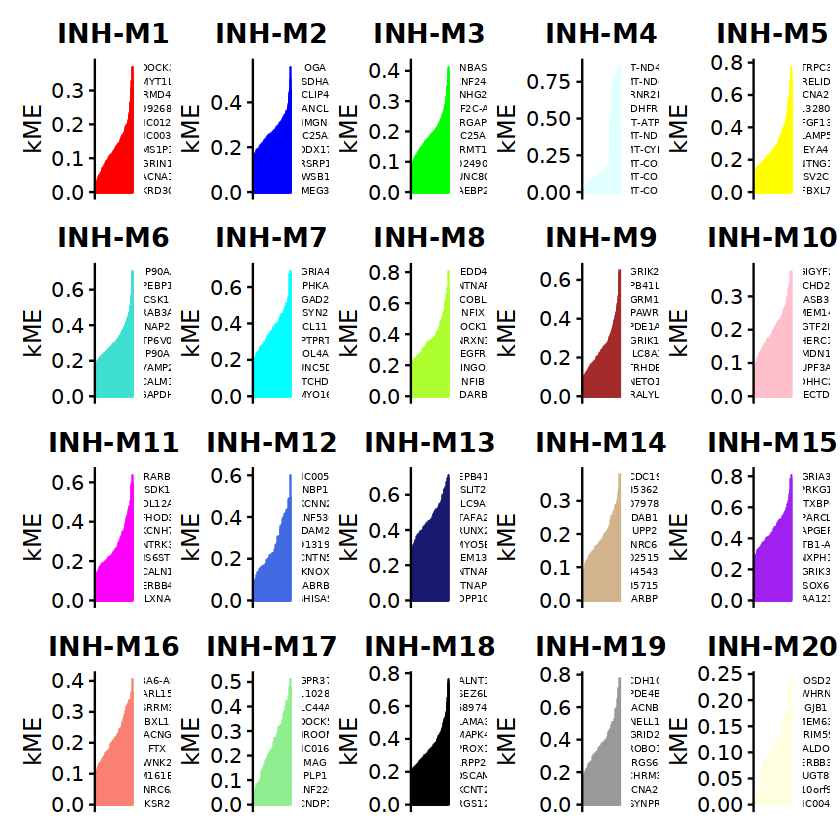

In [19]:
# plot genes ranked by kME for each module
p <- PlotKMEs(seurat_obj, ncol=5)

p

# Getting the module assignment table
hdWGCNA allows for easy access of the module assignment table using the GetModules function. This table consists of three columns: gene_name stores the gene’s symbol or ID, module stores the gene’s module assignment, and color stores a color mapping for each module, which is used in many downstream plotting steps. If ModuleConnectivity has been called on this hdWGCNA experiment, this table will have additional columns for the kME of each module.

In [20]:
# get the module assignment table:
modules <- GetModules(seurat_obj) %>% subset(module != 'grey')

# show the first 6 columns:
head(modules[,1:6])

,gene_name,module,color,kME_grey,kME_INH-M1,kME_INH-M2
,<chr>,<fct>,<chr>,<dbl>,<dbl>,<dbl>
LINC01409,LINC01409,INH-M1,red,0.06366398,0.14184608,0.02143754
INTS11,INTS11,INH-M2,blue,0.19889172,0.04999408,0.22660269
CCNL2,CCNL2,INH-M3,green,0.21444819,0.04736778,0.19980603
GNB1,GNB1,INH-M4,lightcyan,0.24581497,0.03285367,0.20057619
TNFRSF14,TNFRSF14,INH-M5,yellow,0.01307660,0.02396156,0.02342210
TPRG1L,TPRG1L,INH-M6,turquoise,0.10230356,-0.05164874,0.12386259


A table of the top N hub genes sorted by kME can be extracted using the GetHubGenes function.

In [21]:
# get hub genes
hub_df <- GetHubGenes(seurat_obj, n_hubs = 10)

head(hub_df)

,gene_name,module,kME
,<chr>,<fct>,<dbl>
1,ANKRD30BL,INH-M1,0.3719962
2,CACNA1B,INH-M1,0.3709010
3,GRIN1,INH-M1,0.3340728
4,BMS1P14,INH-M1,0.3312609
5,LINC00342,INH-M1,0.3265314
6,LINC01278,INH-M1,0.3101818


This wraps up the critical analysis steps for hdWGCNA, so remember to save your output.

In [22]:
saveRDS(seurat_obj, file='hdWGCNA_object.rds')

# Compute hub gene signature scores
Gene scoring analysis is a popular method in single-cell transcriptomics for computing a score for the overall signature of a set of genes. We can use these methods as alternatives to module eigengenes. hdWGCNA includes the function ModuleExprScore to compute gene scores for a give number of genes for each module, using either the UCell or Seurat algorithm.

In [23]:
# compute gene scoring for the top 25 hub genes by kME for each module
# with UCell method
library(UCell)
seurat_obj <- ModuleExprScore(
  seurat_obj,
  n_genes = 25,
  method='UCell'
)

Selecting by kME_INH-M1
Selecting by kME_INH-M2
Selecting by kME_INH-M3
Selecting by kME_INH-M4
Selecting by kME_INH-M5
Selecting by kME_INH-M6
Selecting by kME_INH-M7
Selecting by kME_INH-M8
Selecting by kME_INH-M9
Selecting by kME_INH-M10
Selecting by kME_INH-M11
Selecting by kME_INH-M12
Selecting by kME_INH-M13
Selecting by kME_INH-M14
Selecting by kME_INH-M15
Selecting by kME_INH-M16
Selecting by kME_INH-M17
Selecting by kME_INH-M18
Selecting by kME_INH-M19
Selecting by kME_INH-M20
Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is INH.M1_UCellINH.M2_UCellINH.M3_UCellINH.M4_UCellINH.M5_UCellINH.M6_UCellINH.M7_UCellINH.M8_UCellINH.M9_UCellINH.M10_UCellINH.M11_UCellINH.M12_UCellINH.M13_UCellINH.M14_UCellINH.M15_UCellINH.M16_UCellINH.M17_UCellINH.M18_UCellINH.M19_UCellINH.M20_UCell; see ?make.names for more details on syntax validity”


# Basic Visualization
Here we showcase some of the basic visualization capabilities of hdWGCNA, and we demonstrate how to use some of Seurat’s built-in plotting tools to visualize our hdWGCNA results. Note that we have a separate tutorial for visualization of the hdWGCNA networks.

# Module Feature Plots
FeaturePlot is a commonly used Seurat visualization to show a feature of interest directly on the dimensionality reduction. hdWGCNA includes the ModuleFeaturePlot function to consruct FeaturePlots for each co-expression module colored by each module’s uniquely assigned color.

[1] "INH-M1"
[1] "INH-M2"
[1] "INH-M3"
[1] "INH-M4"
[1] "INH-M5"
[1] "INH-M6"
[1] "INH-M7"
[1] "INH-M8"
[1] "INH-M9"
[1] "INH-M10"
[1] "INH-M11"
[1] "INH-M12"
[1] "INH-M13"
[1] "INH-M14"
[1] "INH-M15"
[1] "INH-M16"
[1] "INH-M17"
[1] "INH-M18"
[1] "INH-M19"
[1] "INH-M20"


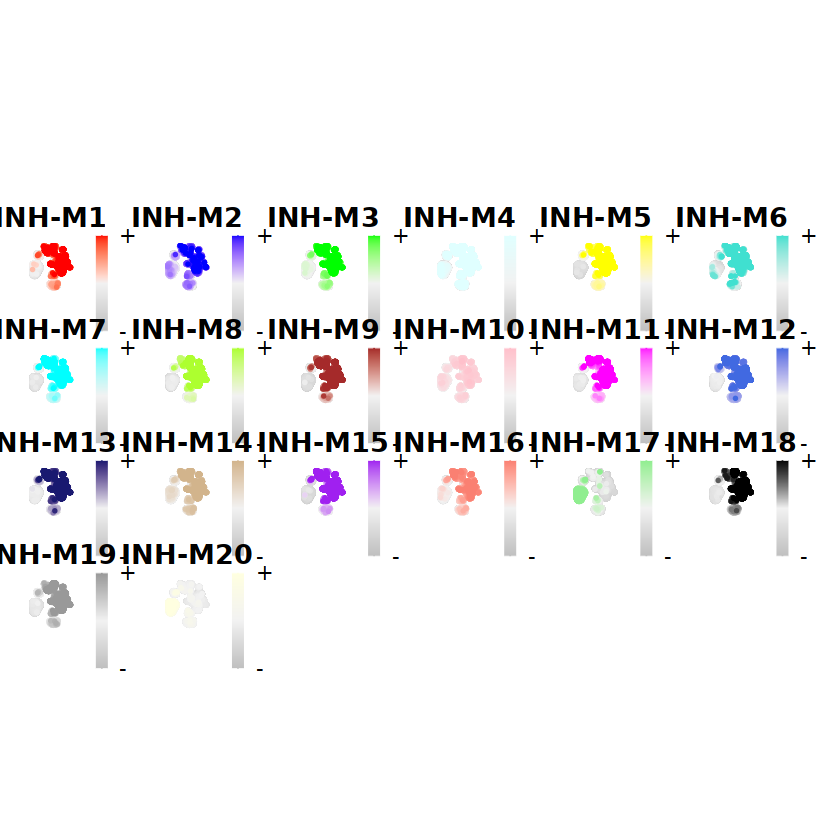

In [24]:
# make a featureplot of hMEs for each module
plot_list <- ModuleFeaturePlot(
  seurat_obj,
  features='hMEs', # plot the hMEs
  order=TRUE # order so the points with highest hMEs are on top
)

# stitch together with patchwork
wrap_plots(plot_list, ncol=6)

We can also plot the hub gene signature score using the same function:

[1] "INH-M1"
[1] "INH-M2"
[1] "INH-M3"
[1] "INH-M4"
[1] "INH-M5"
[1] "INH-M6"
[1] "INH-M7"
[1] "INH-M8"
[1] "INH-M9"
[1] "INH-M10"
[1] "INH-M11"
[1] "INH-M12"
[1] "INH-M13"
[1] "INH-M14"
[1] "INH-M15"
[1] "INH-M16"
[1] "INH-M17"
[1] "INH-M18"
[1] "INH-M19"
[1] "INH-M20"


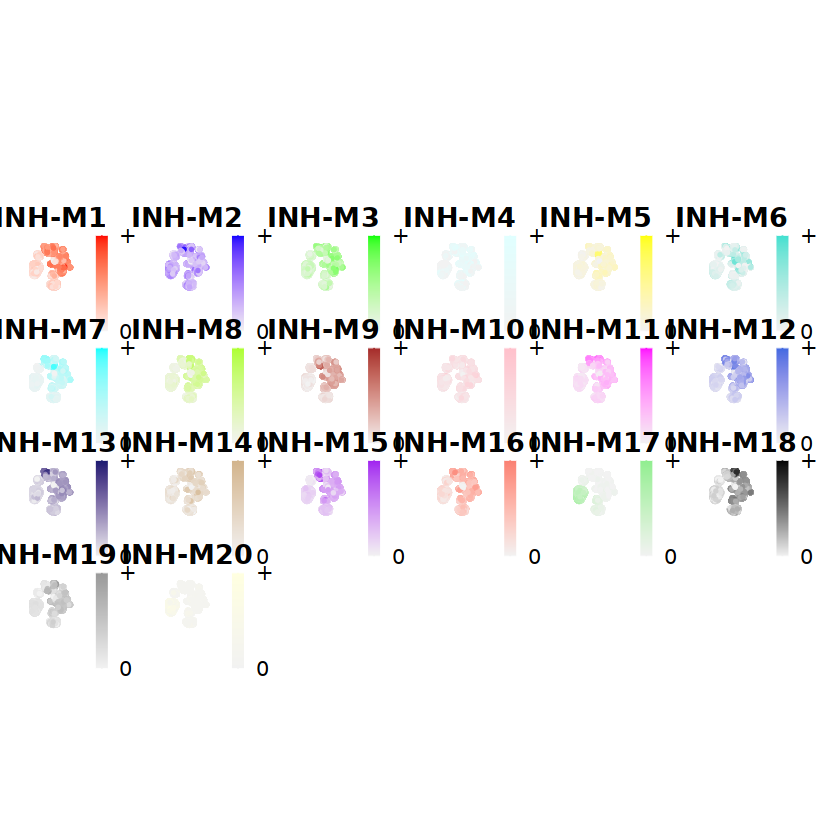

In [25]:
# make a featureplot of hub scores for each module
plot_list <- ModuleFeaturePlot(
  seurat_obj,
  features='scores', # plot the hub gene scores
  order='shuffle', # order so cells are shuffled
  ucell = TRUE # depending on Seurat vs UCell for gene scoring
)

# stitch together with patchwork
wrap_plots(plot_list, ncol=6)

We can also use a radar plot to visualize the relative expression level of each module across different cell groupings. Here we use the function ModuleRadarPlot to visualize the expression of these modules in the INH subclusters.

In [26]:
colnames(seurat_obj@meta.data); unique(seurat_obj$annotation)

[1] "orig.ident"              "nCount_RNA"             
 [3] "nFeature_RNA"            "orig_barcode"           
 [5] "n_counts"                "doublet_scores"         
 [7] "doublets"                "Sample"                 
 [9] "Study"                   "batch"                  
[11] "barcode"                 "individualID"           
[13] "specimenID"              "group"                  
[15] "msex"                    "apoe_genotype"          
[17] "age_death"               "pmi"                    
[19] "braaksc"                 "ceradsc"                
[21] "cogdx"                   "n_genes_by_counts"      
[23] "log1p_n_genes_by_counts" "total_counts"           
[25] "log1p_total_counts"      "total_counts_mt"        
[27] "log1p_total_counts_mt"   "pct_counts_mt"          
[29] "leiden"                  "cell_type"              
[31] "annotation"              "UMAP_1"                 
[33] "UMAP_2"                  "metacell_grouping"

[1] EX9         EX4         EX7         EX5         EX2         <NA>       
 [7] INH2 PVALB+ INH1 VIP+   EX6         INH3 SST+   EX8         EX3        
[13] EX10        INH4 LAMP5+ EX1         ASC2        ASC1        INH5 PVALB+
[19] OPC         MG          ODC2        ASC3        ODC5        ODC1       
[25] ODC3        ODC4       
25 Levels: INH1 VIP+ INH2 PVALB+ INH3 SST+ INH4 LAMP5+ INH5 PVALB+ EX1 ... MG

In [28]:
seurat_obj$cluster <- do.call(rbind, strsplit(as.character(seurat_obj$annotation), ' '))[,1]; unique(seurat_obj$cluster)

[1] "EX9"  "EX4"  "EX7"  "EX5"  "EX2"  NA     "INH2" "INH1" "EX6"  "INH3"
[11] "EX8"  "EX3"  "EX10" "INH4" "EX1"  "ASC2" "ASC1" "INH5" "OPC"  "MG"  
[21] "ODC2" "ASC3" "ODC5" "ODC1" "ODC3" "ODC4"

Loading required package: ggradar

Warning message:
“'plot.data' contains value(s) > grid.max, data scaled to grid.max”
Warning message:
“'plot.data' contains value(s) > grid.max, data scaled to grid.max”
Warning message:
“'plot.data' contains value(s) > grid.max, data scaled to grid.max”
Warning message:
“'plot.data' contains value(s) > grid.max, data scaled to grid.max”
Warning message:
“'plot.data' contains value(s) > grid.max, data scaled to grid.max”
Warning message:
“'plot.data' contains value(s) > grid.max, data scaled to grid.max”
Warning message:
“'plot.data' contains value(s) > grid.max, data scaled to grid.max”
Warning message:
“'plot.data' contains value(s) > grid.max, data scaled to grid.max”
Warning message:
“'plot.data' contains value(s) > grid.max, data scaled to grid.max”
Warning message:
“'plot.data' contains value(s) > grid.max, data scaled to grid.max”
Warning message:
“'plot.data' contains value(s) > grid.max, data scaled to grid.max”
Warning message:
“'plot.data' 

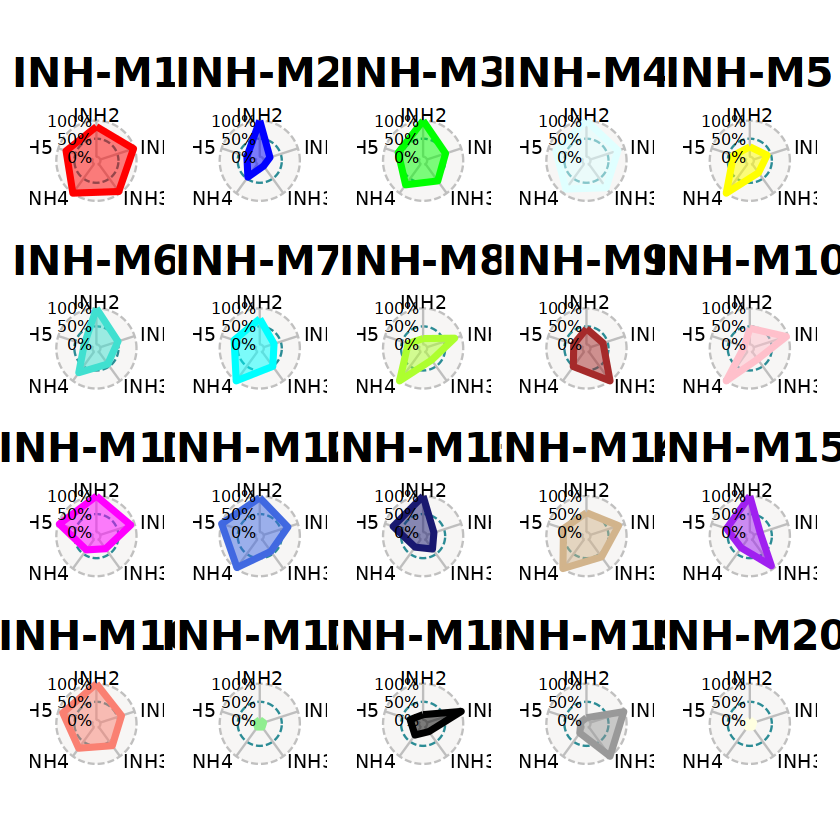

In [29]:
ModuleRadarPlot(
  seurat_obj,
  group.by = 'cluster',
  barcodes = seurat_obj@meta.data %>% subset(cell_type == 'INH') %>% rownames(),
  axis.label.size=4,
  grid.label.size=4
)

Here we can easily visualize which modules are shared across different INH subtypes, like module INH-M1, as well as modules that are expressed more specifically in one subtype like module INH-M18. For this type of plot we do not recommend trying to visualize too many cell groups at once.

Expand to see Module Correlogram
hdWGCNA includes the ModuleCorrelogram function to visualize the correlation between each module based on their hMEs, MEs, or hub gene scores using the R package corrplot.

Warning message in pNew > sig.level:
“longer object length is not a multiple of shorter object length”


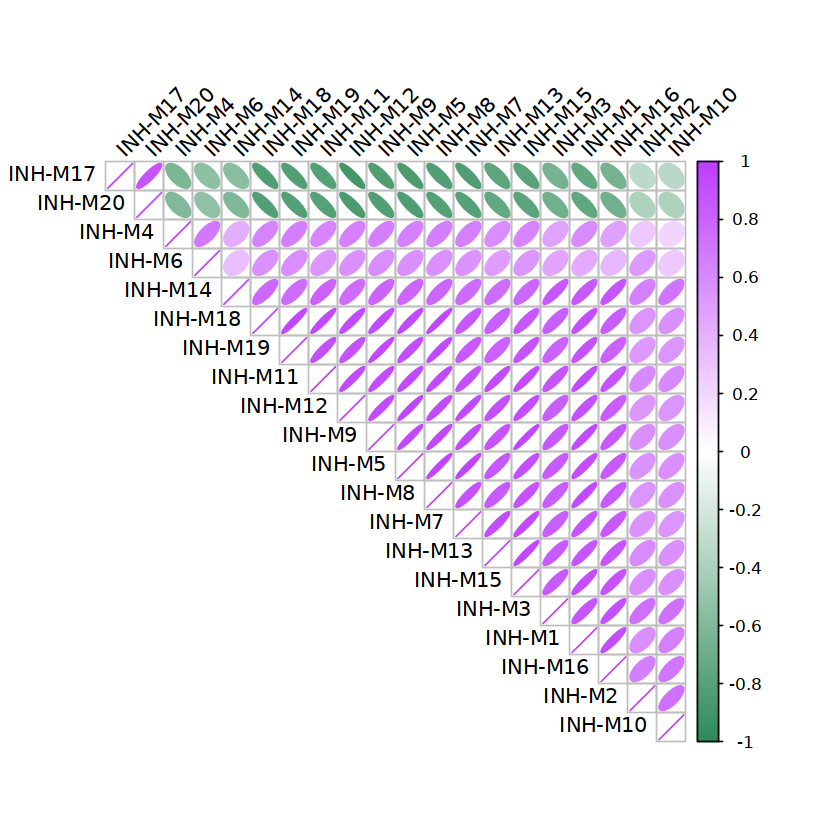

In [30]:
# plot module correlagram
ModuleCorrelogram(seurat_obj)

# Plotting beyond the hdWGCNA package
Sometimes we want to make a custom visualization that may not be included in hdWGCNA. Fortunately, R has an incredible amount of different data visualization packages to take advantage of. The base Seurat plotting functions are also great for visualizing hdWGCNA outputs. Here is a simple example where we visualize the MEs using the Seurat DotPlot function. The key to using Seurat’s plotting functions to visualize the hdWGCNA data is to add it into the Seurat object’s `@meta.data` slot.

In [31]:
# get hMEs from seurat object
MEs <- GetMEs(seurat_obj, harmonized=TRUE)
modules <- GetModules(seurat_obj)
mods <- levels(modules$module); mods <- mods[mods != 'grey']

# add hMEs to Seurat meta-data:
seurat_obj@meta.data <- cbind(seurat_obj@meta.data, MEs)

Now we can easily use Seurat’s DotPlot function:

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


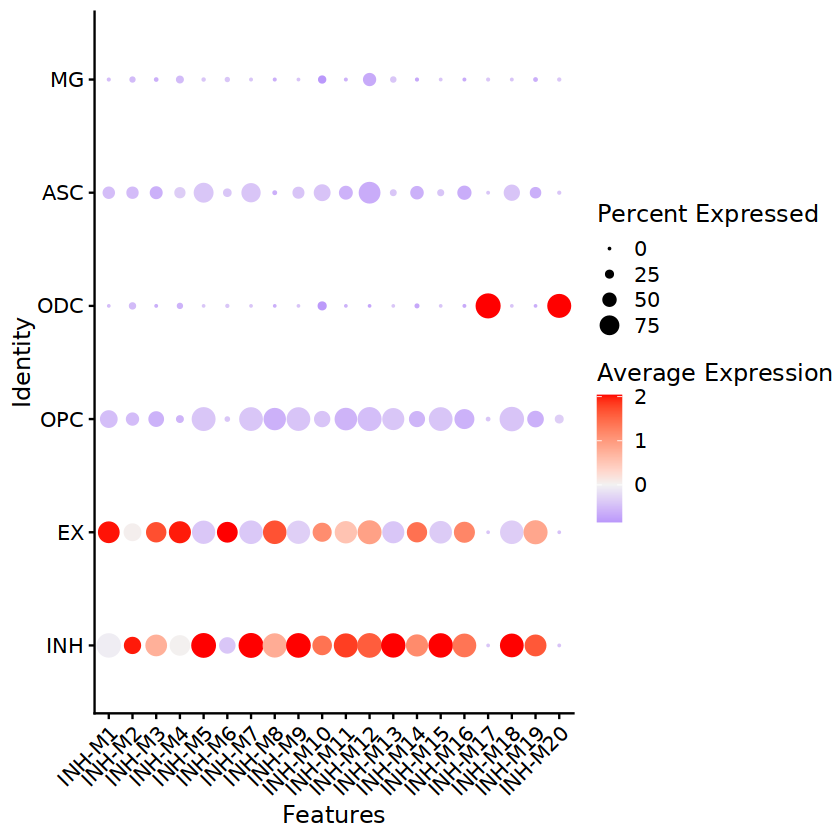

In [32]:
# plot with Seurat's DotPlot function
p <- DotPlot(seurat_obj, features=mods, group.by = 'cell_type')

# flip the x/y axes, rotate the axis labels, and change color scheme:
p <- p +
  RotatedAxis() +
  scale_color_gradient2(high='red', mid='grey95', low='blue')

# plot output
p

Next steps
Now that you have constructed a co-expression network and identified gene modules, there are many downstream analysis tasks which you can take advantage of within hdWGCNA. To provide more depth to your co-expression modules, we encourage you to explore the network visualization tutorial and the enrichment analysis tutorial.

    Network visualization tutorial
    Enrichment tutorial

To compare different biological conditions using hdWGCNA, check out the following tutorials.

    Differential module eigengene (DME) tutorial
    Module preservation tutorial
    Module-trait correlation tutorial
For more advanced analysis, such as Transcription factor regulatory network analysis, please check out the following tutorials.

    Transcription factor regulatory network analysis tutorial
    Protein-protein interaction tutorial
    Consensus network analysis tutorial
    For those interested in running hdWGCNA using pseudobulk replicates rather than metacells, please check out this tutorial.

hdWGCNA with pseudobulk tutorial